# Modeling

Hi! Welcome again

There are four models would be used for our cleaned data:
- Logistic Regression
- XGBoost Classifier
- LightGBM Classifier
- CatBoost Classifier

From the models above, only XGBoost and LightGBM will be done Hyperparameter Tuning with RandomizedSearchCV from scikit-learn library

# Executive Summary

- LGBM Tuned model is seleted for our data since it has the highest score in some metrics we considered
- It has **98%** accuracy, **94,1%** f1-score, **94,9** precision score, and **93,4%** recall score
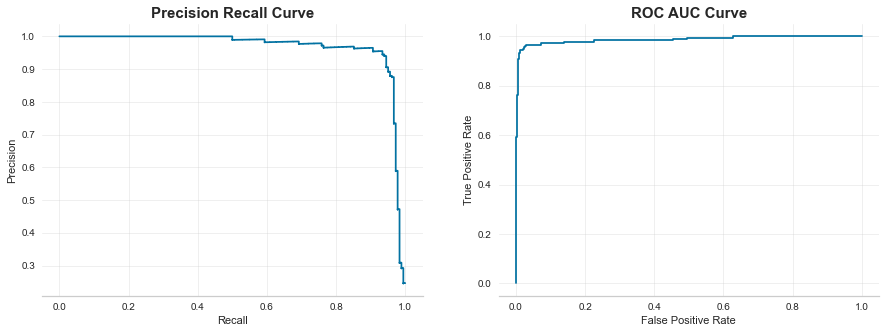

- Three top features:
1. Cashback amount
2. Distance between Warehouse and home
3. Order Amount Hike from last year

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from matplotlib.pyplot import rcParams
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import f1_score, accuracy_score, precision_score, classification_report, confusion_matrix, mean_absolute_error, recall_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [5]:
rcParams['axes.grid']         = True
rcParams['grid.alpha']        = 0.3
rcParams['axes.spines.right'] = False
rcParams['axes.spines.left']  = False
rcParams['axes.spines.top']   = False
rcParams['figure.figsize']    = (17,5)

In [6]:
pd.set_option('display.max_columns',100)
plt.rc('axes',axisbelow=True)

In [7]:
df1 = pd.read_csv('D:Data/UCI/Churn/Cleaned_customer_churn.csv')

In [8]:
X = df1.drop('Churn',axis=1)
y = df1.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, test_size=0.2)

Since this data is imbalance, we would do over sampling method

In [9]:
X_train_new, y_train_new = SMOTE().fit_resample(X_train, y_train)
y_train_new.value_counts()

0.0    3550
1.0    3550
Name: Churn, dtype: int64

In [10]:
models = []
models.append(('LR',LogisticRegression()))
models.append(('XGB',XGBClassifier()))
models.append(('LGBM',LGBMClassifier()))
models.append(('CatBoost',CatBoostClassifier(verbose=False)))

In [11]:
results_boxplot = []
names = []
results_mean = []
results_std = []

for name, model in models:
    cv_results = cross_validate(model, X, y, cv=5,scoring=('accuracy','f1','precision','recall'),n_jobs=-1)
    results_boxplot.append(cv_results)
    # results_mean.append(cv_results.mean())
    # results_std.append(cv_results.std())
    # names.append(name)

In [12]:
pd.DataFrame(results_boxplot, index=[i for i,j in models]).applymap(np.mean)

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
LR,0.053603,0.007400,0.896822,0.636343,0.796322,0.531904
XGB,0.961451,0.015000,0.992710,0.978621,0.979346,0.978058
LGBM,0.212933,0.016401,0.986542,0.959816,0.976240,0.944052
CatBoost,4.773204,0.012200,0.976075,0.926414,0.972676,0.884826


XGBoost looks the best model with the highest all metrics

**Difference error between train and test**

In [13]:
train_score = []
test_score  = []
for name, model in models:
    mod = model.fit(X_train, y_train)
    
    train_score.append(mean_absolute_error(y_train, mod.predict(X_train)))
    test_score.append(mean_absolute_error(y_test, mod.predict(X_test)))

[21:11:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
score = pd.DataFrame({'train_score':train_score,
              'test_score' :test_score
             },index=[name for name, model in models])
score['difference'] = score.train_score- score.test_score
score

,train_score,test_score,difference
LR,0.107477,0.090654,0.016822
XGB,0.000000,0.022430,-0.022430
LGBM,0.002804,0.026168,-0.023364
CatBoost,0.008411,0.041121,-0.032710


Logistic Regression has the smallest difference between train and test error. However, even though XGBoost in the 2nd, it has the smallest error both in train and test set

Let's do hyperparameter tuning for XGB and LGBM

In [15]:
params  = {'learning_rate':[x for x in np.arange(0.05,0.5,0.05)],
          'n_estimators' :[j for j in range(100,1000)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],    
          'gamma': range(1, 9),
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)]
         }

gparams = {'learning_rate':[x for x in np.arange(0.05,0.5,0.02)],
          'n_estimators' :[j for j in range(100,1000)],
          'max_depth':[a for a in range(1,8)],
          'min_child_weight':[b for b in range(1,9)],
          "reg_alpha": [m for m in np.arange(0.1, 0.7,0.09)],
          'booster':['gbdt','rf','dart']
           }

In [16]:
xgb = XGBClassifier()
lgb = LGBMClassifier()

xgb_tuned = RandomizedSearchCV(xgb, params, cv=5,verbose=False,n_jobs=-1,random_state=0,scoring='accuracy')
lgb_tuned = RandomizedSearchCV(lgb, gparams, cv=5,verbose=False,n_jobs=-1,random_state=0,scoring='accuracy')

xgb.fit(X_train_new,y_train_new)
lgb.fit(X_train_new,y_train_new)
xgb_tuned.fit(X_train_new,y_train_new)
lgb_tuned.fit(X_train_new,y_train_new)

[21:11:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'booster': ['gbdt', 'rf', 'dart'],
                                        'learning_rate': [0.05, 0.07,
                                                          0.09000000000000001,
                                                          0.11000000000000001,
                                                          0.13,
                                                          0.15000000000000002,
                                                          0.17000000000000004,
                                                          0.19,
                                                          0.21000000000000002,
                                                          0.23000000000000004,
                                                          0.25000000000000006,
                                                          0.27,
                                              

In [17]:
models_new  = [xgb, lgb, xgb_tuned, lgb_tuned]
f1score     = []
accuracy    = []
recall      = []
precision   = []

for model in models_new:
    f1score.append(f1_score(y_test, model.predict(X_test)))
    accuracy.append(accuracy_score(y_test,model.predict(X_test)))
    recall.append(recall_score(y_test,model.predict(X_test)))
    precision.append(precision_score(y_test,model.predict(X_test)))
    
pd.DataFrame({'f1':f1score,
              'precision':precision,
              'recall':recall,
              'accuracy':accuracy
             },index=['XGB','LGBM','XGB Tuned','LGBM Tuned']).sort_values('f1',ascending=False)

,f1,precision,recall,accuracy
LGBM Tuned,0.933333,0.943820,0.923077,0.977570
XGB,0.927778,0.938202,0.917582,0.975701
LGBM,0.869081,0.881356,0.857143,0.956075
XGB Tuned,0.819209,0.843023,0.796703,0.940187


Only LGBM has a better result after doing hyperparameter tuning. XBG baseline is better than its tuned.

### Precision recall and ROC Curve

In [18]:
y_pred = lgb_tuned.predict_proba(X_test)[:,-1]
prec, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=lgb_tuned.classes_[1])
pr_display = PrecisionRecallDisplay(prec, recall)

In [19]:
auc_score   = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=lgb_tuned.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ROC AUC score: 0.9863317988317988


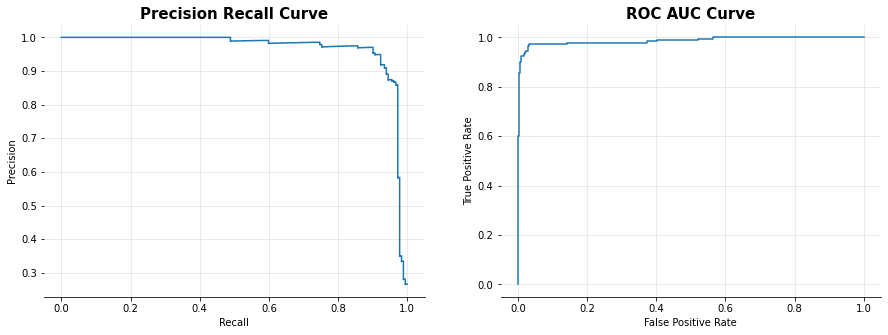

AUC Score: 0.9863317988317988


In [20]:
print('ROC AUC score: {}'.format(auc_score))

fig, ax = plt.subplots(1, 2, figsize= (15,5))

pr_display.plot(ax[0])
roc_display.plot(ax[1])

ax[0].set_title('Precision Recall Curve',size=15, fontweight=550)
ax[1].set_title('ROC AUC Curve',size=15, fontweight=550)

plt.show()
print('AUC Score: {}'.format(auc_score))

### Feature Importance

In [21]:
model_lgb = LGBMClassifier(**{'reg_alpha': 0.1,
 'n_estimators': 703,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002})

In [22]:
model_lgb.fit(X_train_new, y_train_new)

LGBMClassifier(learning_rate=0.15000000000000002, max_depth=6,
               min_child_weight=3, n_estimators=703, reg_alpha=0.1)

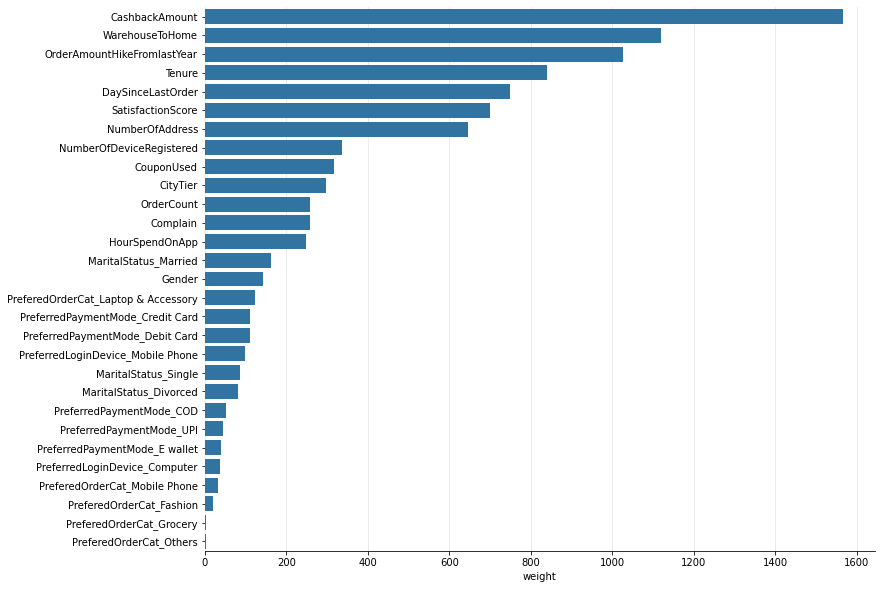

In [23]:
plt.figure(figsize=(12,10))
sns.barplot('weight', 'feature', data=pd.DataFrame({'feature':X_train.columns,'weight':model_lgb.feature_importances_}).sort_values('weight',ascending=False),color='tab:blue')
plt.ylabel('')
plt.show()

# Conclusion